## Importing Packages

In [1]:
"""
Importing (using/include) packages and files needed for the code to run

Topo.jl --- Topography Setup

Note: that we import pyplot last to avoid a name conflict with grid
"""

using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics
using Dates
include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")
include("Temperature.jl")
include("GridOperations.jl")
# Note: that we import pyplot last to avoid a name conflict with grid
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

# Topography Setup

In [2]:
function initial_ice_depth(x::Float64,ice_thickness::Float64,wavelength::Float64,amplitude::Float64,initial_surface_depth::Float64)
    return ice_thickness + initial_surface_depth + amplitude*sin( 2*pi/wavelength*x )
end

function ice_viscosity(T::Float64)
    Q = 40000.0 # Activation Enegry (J/mol)
    R_cont = 8.314 # Gas Constant (J/mol*K)
    ice_vis = (1e15)*exp((Q*(273.0-T))/(R_cont*(273.0*T)))
    upperlimit = 1e25
    lowerlimit = 1e12
    if ice_vis < lowerlimit
        ice_vis = lowerlimit
    elseif ice_vis > upperlimit
        ice_vis = upperlimit
    else 
        ice_vis = ice_vis
    end 
    return ice_vis
end

ice_viscosity (generic function with 1 method)

# Material Setup

In [3]:
struct Materials
    # 1 - subsurface global ocean
    # 2 - icy shell
    # 3 - sticky air
    alpha::Vector{Float64} # Thermal expansion (1/K)
    rho0::Vector{Float64} # Density (kg/m^3)
    Hr::Vector{Float64} # Radiogenic heat production (W/m^3)
    Cp::Vector{Float64} # Heat capacity (J/kg*K)
    kThermal::Vector{Float64} # Thermal conductivity (W/m*K)
    eta::Vector{Float64} # Viscosity (Pa*s)
    function Materials()
        new([0.0,0.0,0.0],[1000.0,920.0,1.0],[0.0,0.0,0.0],[4180.0,2100.0,1.0e6],[0.5610,2.1,0.024],[1e12,1e15,1e17])
    end    
end

function update_marker_prop!(markers::Markers,materials::Materials)
    eta = markers.scalarFields["eta"]
    rho = markers.scalarFields["rho"]
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        markers.scalars[rho,i] = materials.rho0[mmat[i]]
        if mmat[i] == 2
            markers.scalars[eta,i] = ice_viscosity(markers.scalars[T,i])
        end
    end
end

function update_marker_temp!(markers::Markers,materials::Materials)
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        if mmat[i] == 1 
            markers.scalars[T,i] = 273.0
        elseif mmat[i] == 3 
            markers.scalars[T,i] = 100.0
        end 
    end 
end 

function initial_conditions!(markers::Markers,materials::Materials,options::Dict)
    material = markers.integerFields["material"]
    T = markers.scalarFields["T"]
    eta = markers.scalarFields["eta"]
    alpha = markers.scalarFields["alpha"]
    Cp = markers.scalarFields["Cp"]
    Hr = markers.scalarFields["Hr"]
    kThermal = markers.scalarFields["kThermal"]
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        hice = initial_ice_depth(mx,options["ice thickness"],options["wavelength"],options["amplitude"],options["surface depth"])
        hsurf = options["surface depth"]
        if my > hice
            # subsurface global ocean
            markers.integers[material,i] = 1
            markers.scalars[T,i] = 273.0
            markers.scalars[eta,i] = materials.eta[1]
            markers.scalars[alpha,i] = materials.alpha[1]        
            markers.scalars[Cp,i] = materials.Cp[1]
            markers.scalars[Hr,i] = materials.Hr[1] 
            markers.scalars[kThermal,i] = materials.kThermal[1]
        elseif my > hsurf
            # icy shell
            markers.integers[material,i] = 2
            markers.scalars[T,i] = 100.0+((273.0-100.0)/(hice-hsurf))*(my-hsurf)
            # markers.scalars[eta,i] = eta_i[i]
            markers.scalars[alpha,i] = materials.alpha[2]
            markers.scalars[Cp,i] = materials.Cp[2]
            markers.scalars[Hr,i] = materials.Hr[2]
            markers.scalars[kThermal,i] = materials.kThermal[2]
        else
            # sticky air
            markers.integers[material,i] = 3
            markers.scalars[T,i] = 100.0            
            markers.scalars[eta,i] = materials.eta[3]
            markers.scalars[alpha,i] = materials.alpha[3]  
            markers.scalars[Cp,i] = materials.Cp[3]
            markers.scalars[Hr,i] = materials.Hr[3]
            markers.scalars[kThermal,i] = materials.kThermal[3]
        end
    end 
    # end loop over markers
    update_marker_prop!(markers,materials)
end

function get_interface(grid::CartesianGrid,mat::Matrix{Float64},contour_value::Float64)
    # Finding interfaces 
    interface_position = zeros(Float64,grid.nx+1);
    for j in 1:grid.nx+1
        i = 1
        while i <= grid.ny
            if mat[i,j] == contour_value
                interface_position[j] = grid.yc[i]
                break
            elseif mat[i+1,j] < contour_value
                # interface is located within this cell.
                interface_position[j] = grid.yc[i] + (grid.yc[i+1]-grid.yc[i])/(mat[i+1,j]-mat[i,j])*(contour_value-mat[i,j])
                break
            end
            i = i+1
        end
    end
    return interface_position
end

include("Topo.jl")
include("FittingData.jl")

fitting_data (generic function with 1 method)

# Model Setup

In [4]:
options = Dict()
options["surface depth"] = 1e4
options["ice thickness"] = 1e4
options["wavelength"] = 1e4
options["amplitude"] = 1e3

function run(options::Dict)
    W = options["wavelength"]
    H = options["ice thickness"] + options["surface depth"] + options["amplitude"] + 1e4
    ny = 251
    nx = Int64(ceil(W/H*ny))
    
    gx = 0.0
    gy = 1.3


    # Tbctype = [-1,-1,1,1] #left, right, top, bottom
    Tbctype = [-1,-1,1,1]
    # Tbcval = [0.0,0.0,100.0,273.0] #left, right, top, bottom
    Tbcval = [0.0,0.0,100.0,273.0]
    bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.
    materials = Materials()

    markx = 6
    marky = 6
    seconds_in_year = 3.15e7
    plot_interval = 1e6*seconds_in_year # plot interval in seconds
    end_time = 3e7*seconds_in_year
    dtmax = plot_interval
    grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    @time markers = Markers(grid,["alpha","T","rho","eta","Cp","Hr","kThermal"],["material"] ; nmx=markx,nmy=marky,random=true)
    println("Initial condition...")
    @time initial_conditions!(markers, materials,options)

    local time_plot = []
    local max_topo = []
    local topography = []
    ### Setting up agruments for interface function ###
    # initial 
    i_mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")
    i_air_ice_interface = get_interface(grid,i_mat,2.5)
    i_ocean_ice_interface = get_interface(grid,i_mat,1.5)

    ### Setting up agruments for termination criteria ###
    max_step::Int64=100
    max_time::Float64=-1.0
    max_time = max_time == -1.0 ? typemax(Float64) : max_time
    max_step = max_step == -1 ? typemax(Int64) : max_step

    # # define arrays for k, rho, cp, H at the basic nodes. Fill them with constant values for now.
    # kThermal = 3.0 .*ones(grid.ny,grid.nx);

    time = 0.0
    iout= 0
    last_plot = 0.0
    dt = 1e10

    rho_c = nothing
    rho_vx = nothing 
    rho_vy = nothing 
    alpha = nothing 
    Hr = nothing 
    Cp_c = nothing 
    eta_s = nothing 
    eta_n = nothing 
    vxc = nothing 
    vyc = nothing 
    T = nothing 
    dTmax = nothing 
    dTemp = nothing 
    Tnew = nothing 
    Tlast = nothing 
    x_time = nothing
    kThermal = nothing
    ocean_ice_interface = nothing
    mat = nothing

    itime = 1
    output_dir = "test"

    terminate = false
    while !terminate
        # 0. update the markers properties  
        update_marker_prop!(markers,materials)
        update_marker_temp!(markers,materials)
        #update_interface_temp!(markers,materials)
        # 1. Transfer properties markers -> nodes
        # 1a. Basic Nodes
        eta_s_new, = marker_to_stag(markers,grid,["eta",],"basic")
        # 1b. Cell Centers
        rho_c_new,Cp_c_new,alpha_new,eta_n_new,Tlast_new,Hr_new,kThermal_new = marker_to_stag(markers,grid,["rho","Cp","alpha","eta","T","Hr","kThermal"],"center")
        # 1c. Vx and Vy nodes:
        rho_vx_new, = marker_to_stag(markers,grid,["rho",],"vx")
        rho_vy_new, = marker_to_stag(markers,grid,["rho",],"vy") 

        # deal with any NaN values from interpolation:
        if itime > 1
            if any(isnan.(eta_s_new))
                println("found nan values")
            end
            replace_nan!(eta_s,eta_s_new)
            replace_nan!(rho_c,rho_c_new)
            replace_nan!(Hr,Hr_new)
            replace_nan!(Cp_c,Cp_c_new)
            replace_nan!(alpha,alpha_new)
            replace_nan!(eta_n,eta_n_new)
            replace_nan!(Tlast,Tlast_new)
            replace_nan!(rho_vx,rho_vx_new)
            replace_nan!(rho_vy,rho_vy_new)
            replace_nan!(kThermal,kThermal_new)
        end
        # Copy field data 
        kThermal = copy(kThermal_new)
        rho_vx = copy(rho_vx_new)
        rho_vy = copy(rho_vy_new)
        rho_c = copy(rho_c_new)
        Hr = copy(Hr_new)
        Cp_c = copy(Cp_c_new)
        alpha = copy(alpha_new)
        eta_s = copy(eta_s_new)
        eta_n = copy(eta_n_new)
        Tlast = copy(Tlast_new)

        if itime == 1 
            ghost_temperature_center(grid,Tlast,Tbctype,Tbcval)
            cell_center_to_markers!(markers,grid,Tlast,markers.scalars[[markers.scalarFields["T"],],:])
        else
            ghost_temperature_center(grid,Tlast,Tbctype,Tbcval)
        end

        # 2. Assemble and solve the stokes equations
        L,R = form_stokes(grid,eta_s,eta_n,rho_vx,rho_vy,bc,gx,gy;dt=dt)
        stokes_solution = L\R
        vx,vy,P = unpack(stokes_solution,grid;ghost=true)

        # Get the velocity at the cell centers:
        vxc,vyc = velocity_to_centers(grid,vx,vy)
        adiabatic_heating = compute_adiabatic_heating(grid,rho_c,Tlast,alpha,gx,gy,vxc,vyc)*0.0
        shear_heating = compute_shear_heating(grid,vx,vy,eta_n,eta_s)*0.0
        H = (adiabatic_heating .+ shear_heating .+ Hr).*0.0

        # 3. Compute the advection timestep
        if itime > 1
            this_dtmax = min(1.2*dt,dtmax)
        else
            this_dtmax = dtmax
        end
        dt = compute_timestep(grid,vxc,vyc;dtmax=this_dtmax,cfl=0.25)
        diffusion_timestep = (grid.x[2]-grid.x[1])^2 / 1e-6
        if dt > diffusion_timestep
            dt = diffusion_timestep
        end

        dTmax = Inf
        dTemp = nothing
        Tnew = nothing
        titer = 1
        for titer=1:2
            # assemble and solve the energy equation
            println("Trying with timestep ",dt/seconds_in_year/1e3," kyr")
            
            L,R = assemble_energy_equation_center(grid,rho_c,Cp_c,kThermal,H,Tlast,dt,Tbctype,Tbcval)
            Tnew = L\R;
            Tnew = reshape(Tnew,grid.ny,grid.nx);
            Tnew = ghost_temperature_center(grid,Tnew,Tbctype,Tbcval)
            T = copy(Tnew)

            dTemp = Tnew-Tlast
            # compute the maximum temperature change
            dTmax = maximum(abs.(dTemp[2:end-1,2:end-1]))
                
            println("dTmax=",dTmax," dt=",dt/seconds_in_year/1e3," kyr")
            
            dt = min(dt,dTmax < 10.0 ? dt : dt*10.0/dTmax)
            if dTmax < 10.0
                break
            end
        end

        dT_subgrid_node = subgrid_temperature_relaxation_center!(markers,grid,Tlast,Cp_c[1,1],kThermal[1,1],dt)
        dT_remaining = dTemp - dT_subgrid_node

        cell_center_change_to_markers!(markers,grid,dT_remaining,"T")

        # Checking Termination Criteria, time is in Myr
        if time >= max_time || itime >= max_step
            terminate = true
        end    

        # println("Min/Max velocity: ",minimum(vyc)," ",maximum(vyc))            
        # Moving the markers and advancing to the next timestep
        move_markers_rk4!(markers,grid,vx,vy,dt,continuity_weight=1/3)
        time += dt
        itime += 1
        
        println("Finished Step ",itime," time=",time/seconds_in_year/1e3," kyr")

        x_time = @sprintf("%.3g",time/3.15e7/1e6);
        mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")
        ocean_ice_interface = get_interface(grid,mat,1.5)
        air_ice_interface = get_interface(grid,mat,2.5)
        append!(time_plot,time)
        append!(topography,[ocean_ice_interface])
    end
    return grid,i_mat,mat,time_plot,topography
end

grid,i_mat,mat,times,topography = run(options)


air_ice_interface = get_interface(grid,mat,2.5)
ocean_ice_interface = get_interface(grid,mat,1.5)
i_air_ice_interface = get_interface(grid,i_mat,2.5)
i_ocean_ice_interface = get_interface(grid,i_mat,1.5)

# figure()
# scatter(markers.x[1,:],markers.x[2,:],c="b",s=0.1)
# show()

Creating Markers...
  0.052272 seconds (19 allocations: 74.159 MiB, 63.80% gc time)
Initial condition...
  0.517429 seconds (5.71 M allocations: 90.258 MiB, 6.20% gc time, 13.30% compilation time)
Trying with timestep 0.07735046578935935 kyr
dTmax=0.25290422660100376 dt=0.07735046578935935 kyr
Finished Step 2 time=0.07735046578935935 kyr
Trying with timestep 0.07622915430608573 kyr
dTmax=0.24519842267505965 dt=0.07622915430608573 kyr
Finished Step 3 time=0.15357962009544507 kyr
Trying with timestep 0.07686809660620816 kyr
dTmax=0.2292990536752768 dt=0.07686809660620816 kyr
Finished Step 4 time=0.23044771670165326 kyr
Trying with timestep 0.07765288248124773 kyr
dTmax=0.2035601912795073 dt=0.07765288248124773 kyr
Finished Step 5 time=0.30810059918290095 kyr
Trying with timestep 0.078526232824529 kyr
dTmax=0.18160668920660328 dt=0.078526232824529 kyr
Finished Step 6 time=0.38662683200743 kyr
Trying with timestep 0.07937549274678724 kyr
dTmax=0.1734768475986357 dt=0.07937549274678724 kyr


Finished Step 58 time=8.340489662471573 kyr
Trying with timestep 0.3993557180807643 kyr
dTmax=0.8259207812743057 dt=0.3993557180807643 kyr
Finished Step 59 time=8.739845380552337 kyr
Trying with timestep 0.43223262857279265 kyr
dTmax=0.8944141493309417 dt=0.43223262857279265 kyr
Finished Step 60 time=9.172078009125128 kyr
Trying with timestep 0.47039012071263253 kyr
dTmax=0.9719941898649154 dt=0.47039012071263253 kyr
Finished Step 61 time=9.642468129837763 kyr
Trying with timestep 0.49603174603174605 kyr
dTmax=1.0207211128877702 dt=0.49603174603174605 kyr
Finished Step 62 time=10.13849987586951 kyr
Trying with timestep 0.49603174603174605 kyr
dTmax=1.0394930306838432 dt=0.49603174603174605 kyr
Finished Step 63 time=10.634531621901255 kyr
Trying with timestep 0.49603174603174605 kyr
dTmax=1.0512592428607945 dt=0.49603174603174605 kyr
Finished Step 64 time=11.130563367933 kyr
Trying with timestep 0.49603174603174605 kyr
dTmax=1.0650301423406745 dt=0.49603174603174605 kyr
Finished Step 65

82-element Vector{Float64}:
 20009.711734990313
 20050.563245099773
 20108.93790329134
 20199.559095701887
 20276.529058568576
 20342.8414499984
 20417.672249210373
 20482.071419079355
 20561.314668259292
 20613.394653273706
 20685.802151783915
 20724.215493274587
 20792.335074200146
     ⋮
 19259.60572855487
 19332.944930166203
 19375.186610314973
 19449.98351322809
 19504.75027862525
 19585.710363390026
 19649.044800298427
 19722.124631087154
 19811.843220132076
 19873.68188091607
 19954.01268241673
 19976.681018117866

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


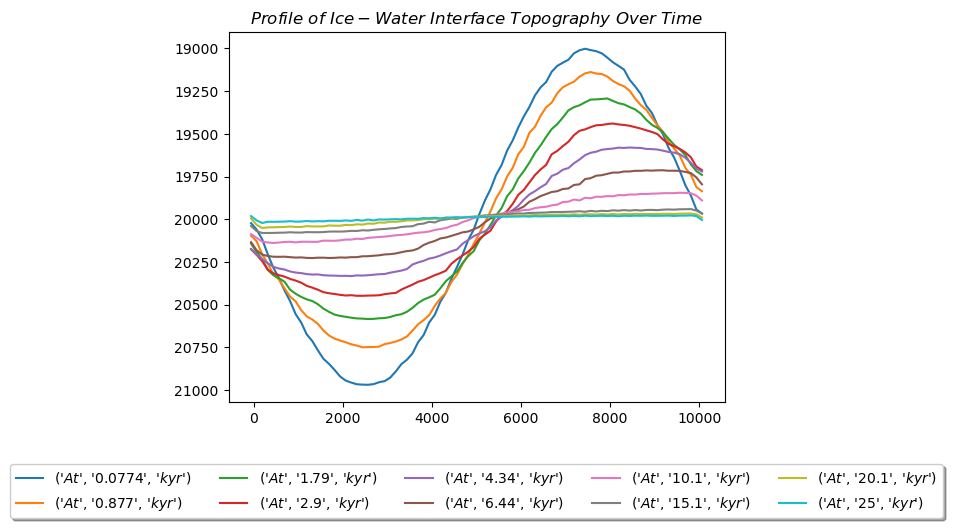

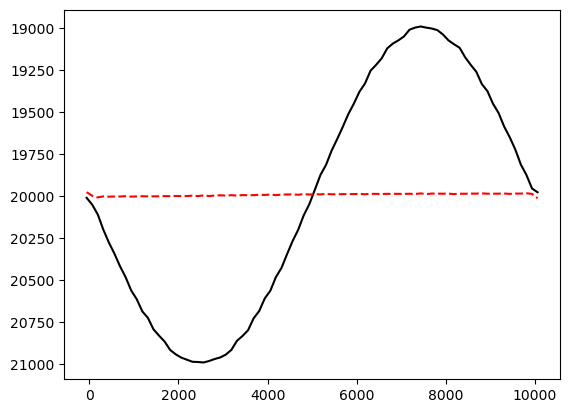

In [5]:
# Profile of ice-water inferface topograpgy over time 
figure()
for i in 1:10:100
    plot(grid.xc,topography[i],label=(L"At",@sprintf("%.3g",times[i]/3.15e7/1e3),L"kyr"))
end
title(L"Profile\,\,of\,\,Ice-Water\,\,Interface\,\,Topography\,\,Over\,\,Time")
# gca().set_xlim([0.0,1e4])
# gca().set_ylim([1.8e4,2.2e4])
gca().invert_yaxis()
# Legend is at the bottom
legend(loc="upper center", bbox_to_anchor=(0.5, -0.15),fancybox="True",shadow="True", ncol=5)
show()
       
figure()
plot(grid.xc,i_ocean_ice_interface,"k")
plot(grid.xc,ocean_ice_interface,"r--")
gca().invert_yaxis()
show()

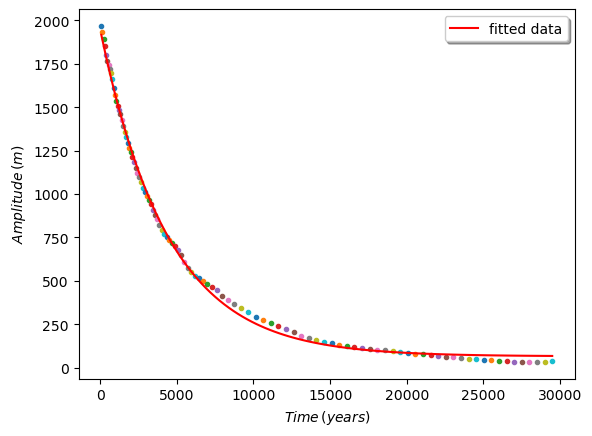

In [7]:
fitting_data(topography,times,100)

The maximum total initial thickness of the icy shell is 11(km)
The average initial thickness of the icy shell is 9.99(km)
The initial amplitude is 0.991(km)

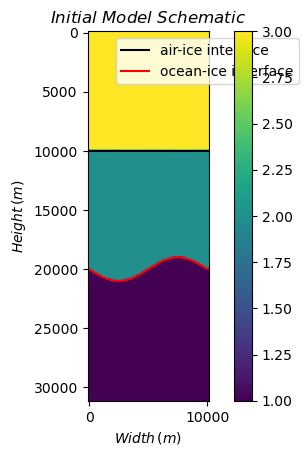

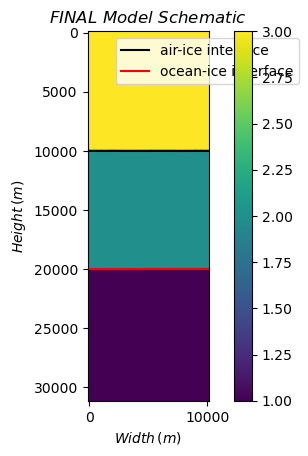

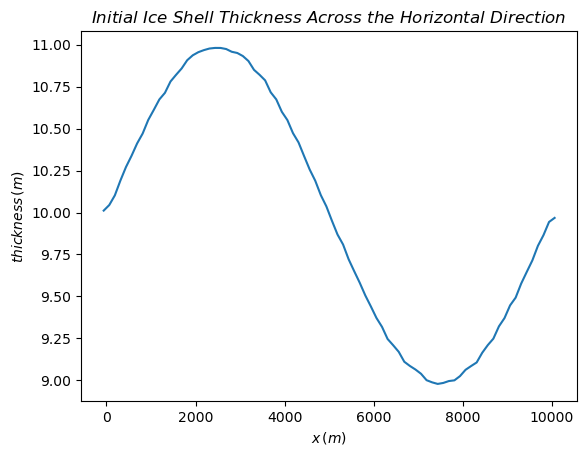

In [8]:
println("The maximum total initial thickness of the icy shell is ",@sprintf("%.3g",maximum(i_ocean_ice_interface-i_air_ice_interface)/1000),"(km)")
i_ice_avg = mean(i_ocean_ice_interface-i_air_ice_interface)
println("The average initial thickness of the icy shell is ",@sprintf("%.3g",i_ice_avg/1000),"(km)")
i_amp = (maximum(i_ocean_ice_interface-i_air_ice_interface)-i_ice_avg)
print("The initial amplitude is ",@sprintf("%.3g",i_amp/1000),"(km)")

# Inital Model Schematic Profile
figure() 
pcolor(grid.xc,grid.yc,i_mat)
colorbar()
plot(grid.xc,i_air_ice_interface,"k",label="air-ice interface")
plot(grid.xc,i_ocean_ice_interface,"r",label="ocean-ice interface")
title(L"Initial\,\,Model\,\,Schematic")
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(m)")
gca().set_xlabel(L"Width\,(m)")
legend(loc="upper right",bbox_to_anchor=[1.8,1.0])
show()

# Final Model Schematic Profile
figure() 
pcolor(grid.xc,grid.yc,mat)
colorbar()
plot(grid.xc,air_ice_interface,"k",label="air-ice interface")
plot(grid.xc,ocean_ice_interface,"r",label="ocean-ice interface")
title(L"FINAL\,\,Model\,\,Schematic")
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(m)")
gca().set_xlabel(L"Width\,(m)")
legend(loc="upper right",bbox_to_anchor=[1.8,1.0])
show()

# Initial ice shell thickness profile along the horizontal direction
figure() 
plot(grid.xc,(i_ocean_ice_interface-i_air_ice_interface)/1000)
title(L"Initial\,\,Ice\,\,Shell\,\,Thickness\,\,Across\,\,the\,\,Horizontal\,\,Direction")
gca().set_ylabel(L"thickness\,(m)")
gca().set_xlabel(L"x\,(m)")
show()

In [ ]:
# i_max_ice_shell_thickness = maximum(i_ocean_ice_interface.-i_air_ice_interface)
# i_avg_ice_shell_thickness = mean(i_ocean_ice_interface.-i_air_ice_interface)
# i_amplitude = i_max_ice_shell_thickness-i_avg_ice_shell_thickness

# max_ice_shell_thickness = maximum(ocean_ice_interface.-air_ice_interface)
# avg_ice_shell_thickness = mean(ocean_ice_interface.-air_ice_interface)
# amplitude = max_ice_shell_thickness-avg_ice_shell_thickness

# display(i_amplitude)
# display(amplitude)

In [ ]:
# get_topography_info(i_air_ice_interface,i_ocean_ice_interface,"initial");

In [ ]:
# get_topography_info(air_ice_interface,ocean_ice_interface,"final");

In [ ]:
# get_topography_plots(i_mat,i_air_ice_interface,i_ocean_ice_interface,topography,max_topo,times,"initial");

In [ ]:
# get_topography_plots(mat,air_ice_interface,ocean_ice_interface,topography,max_topo,times,"final");

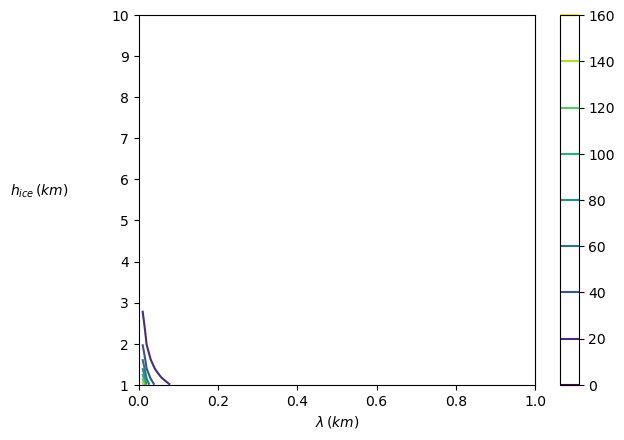

In [250]:
f(lambda,hice) = get_time_viscous(lambda*1e3)/get_thickening_time(hice*1e3)
lambda = LinRange(0,1,100)
hice = LinRange(1,10,50)
z = @.f(lambda',hice)

figure()
contour(lambda,hice,z,color=:viridis)
# gca().set_aspect("equal")
gca().set_ylabel(L"h_{ice}\,(km)",rotation=0)
gca().set_xlabel(L"\lambda\,(km)")
# gca().set_yscale("log")
# gca().set_xscale("log")
gca().yaxis.set_label_coords(-0.25,0.5)
colorbar()
show()

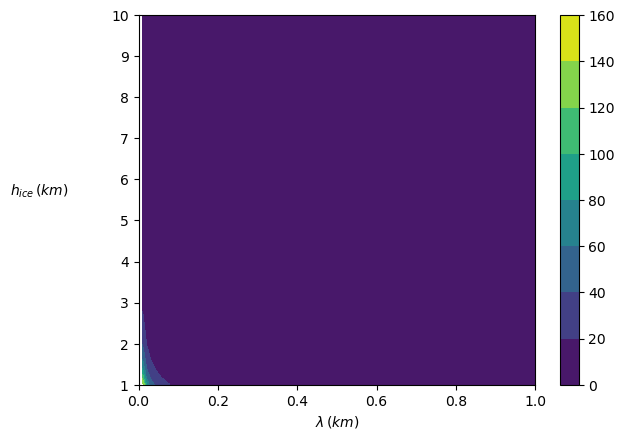

In [252]:
f(x,y) = get_time_viscous(x*1e3)/get_thickening_time(y*1e3)
x = LinRange(0,1,100)
y = LinRange(1,10,51)
# x = range(start = 0, stop = 1, length = 100)
# y = range(start = 1, stop = 10, length = 51)
z = @.f(x',y)

figure()
contourf(x,y,z,color=:viridis)
# gca().set_aspect("equal")
gca().set_ylabel(L"h_{ice}\,(km)",rotation=0)
gca().set_xlabel(L"\lambda\,(km)")
# gca().set_yscale("log")
# gca().set_xscale("log")
gca().yaxis.set_label_coords(-0.25,0.5)
colorbar()
show()